### Importando as bibliotecas

In [120]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

### Definação da classe MLP

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt


class MLPClassifier:
    def __init__(self, hidden_layers=[64, 32], activation='relu', learning_rate=0.01,
                 epochs=100, patience=5, batch_size=32, optimizer='sgd', regularization='None',
                 dropout_p=0.1, lambda_l2=0.001, random_state=None):

        self.hidden_layers = hidden_layers
        self.activation = activation.lower()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.optimizer = optimizer.lower()
        self.regularization = regularization
        self.dropout_p = dropout_p
        self.lambda_l2 = lambda_l2
        self.random_state = random_state

        self.model = None
        self.loss_history = {'train': [], 'val': []}
        self.accuracy_history = {'train': [], 'val': []}
        self.classes_ = None

        # CPU apenas
        self.device = torch.device("cpu")
        print("Usando dispositivo: CPU")
        print(f"Cuda habilitado? {torch.cuda.is_available()}")

        if random_state is not None:
            torch.manual_seed(random_state)
            np.random.seed(random_state)

    
    def _build_model(self, input_dim, output_dim):
        layers = []
        prev_dim = input_dim

        for dim in self.hidden_layers:
            layers.append(nn.Linear(prev_dim, dim))

            if self.activation == 'relu':
                layers.append(nn.ReLU())
            elif self.activation == 'tanh':
                layers.append(nn.Tanh())
            
            if self.regularization == 'dropout':
                layers.append(nn.Dropout(p=self.dropout_p))

            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, output_dim))

        return nn.Sequential(*layers).to(self.device)

    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        start = time.time()

        # Tensores CPU
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.LongTensor(y_train).to(self.device)

        if X_val is not None and y_val is not None:
            X_val_tensor = torch.FloatTensor(X_val).to(self.device)
            y_val_tensor = torch.LongTensor(y_val).to(self.device)
            validation_data = (X_val_tensor, y_val_tensor)
        else:
            validation_data = None

        # Inicializar modelo
        input_dim = X_train.shape[1]
        self.classes_ = torch.unique(y_train_tensor)
        output_dim = len(self.classes_)

        self.model = self._build_model(input_dim, output_dim)

        criterion = nn.CrossEntropyLoss() if output_dim > 1 else nn.BCEWithLogitsLoss()

        # Otimizador
        if self.optimizer == 'sgd':
            optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        elif self.optimizer == 'adam':
            if self.regularization == 'l2':
                optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.lambda_l2)
            else:
                optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("O otimizador deve ser 'sgd' ou 'adam'.")
        
        # Early stopping
        best_loss = np.inf
        patience_counter = 0
        best_weights = None

        # Loop de treinamento
        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            for i in range(0, len(X_train), self.batch_size):
                batch_X = X_train_tensor[i:i+self.batch_size]
                batch_y = y_train_tensor[i:i+self.batch_size]

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)

            # Métricas
            train_loss = epoch_loss / (len(X_train) / self.batch_size)
            train_acc = correct / total
            self.loss_history['train'].append(train_loss)
            self.accuracy_history['train'].append(train_acc)

            # Validação
            val_loss, val_acc = None, None
            if validation_data is not None:
                self.model.eval()
                with torch.no_grad():
                    Xv, yv = validation_data
                    outputs = self.model(Xv)
                    val_loss = criterion(outputs, yv).item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_acc = (predicted == yv).sum().item() / len(yv)

                self.loss_history['val'].append(val_loss)
                self.accuracy_history['val'].append(val_acc)

                # Early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    best_weights = self.model.state_dict()
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping na época {epoch+1}")
                        self.model.load_state_dict(best_weights)
                        break

            # Log
            if (epoch+1) % 10 == 0 or epoch == 0:
                msg = f"Época {epoch+1}/{self.epochs} - Loss Treino: {train_loss:.4f}, Acc: {train_acc*100:.2f}%"
                if val_loss is not None:
                    msg += f", Loss Val: {val_loss:.4f}, Acc Val: {val_acc*100:.2f}%"
                print(msg)

        end = time.time()
        print(f"Tempo total de treinamento: {end - start:.2f} segundos")

    
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("O modelo não foi treinado ainda. Chame fit() primeiro.")

        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs.data, 1)
        return predictions.cpu().numpy()

    
    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.plot(self.loss_history['train'], label='Treino')
        if len(self.loss_history['val']):
            ax1.plot(self.loss_history['val'], label='Validação')
        ax1.set_title('Loss')
        ax1.set_xlabel('Época')
        ax1.legend()

        ax2.plot(self.accuracy_history['train'], label='Treino')
        if len(self.accuracy_history['val']):
            ax2.plot(self.accuracy_history['val'], label='Validação')
        ax2.set_title('Acurácia')
        ax2.set_xlabel('Época')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    
    def plot_decision_boundary(self, X, y, step=0.02):
        if X.shape[1] != 2:
            print("A fronteira de decisão só pode ser plotada para dados 2D.")
            return

        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                             np.arange(y_min, y_max, step))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        predictions = self.predict(grid_points).reshape(xx.shape)

        plt.contourf(xx, yy, predictions, alpha=0.75)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        plt.title('Fronteira de Decisão')
        plt.show()

### 1° Caso

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.8087, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7527, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7112, Acc: 63.95%
Época 30/100 - Loss Treino: 0.6623, Acc: 89.80%
Época 40/100 - Loss Treino: 0.5940, Acc: 89.80%
Época 50/100 - Loss Treino: 0.5136, Acc: 90.48%
Época 60/100 - Loss Treino: 0.4301, Acc: 90.48%
Época 70/100 - Loss Treino: 0.3560, Acc: 91.84%
Época 80/100 - Loss Treino: 0.2988, Acc: 91.84%
Época 90/100 - Loss Treino: 0.2579, Acc: 93.88%
Época 100/100 - Loss Treino: 0.2289, Acc: 93.88%
Tempo total de treinamento: 0.31 segundos

Acurácia do Teste: 85.71%


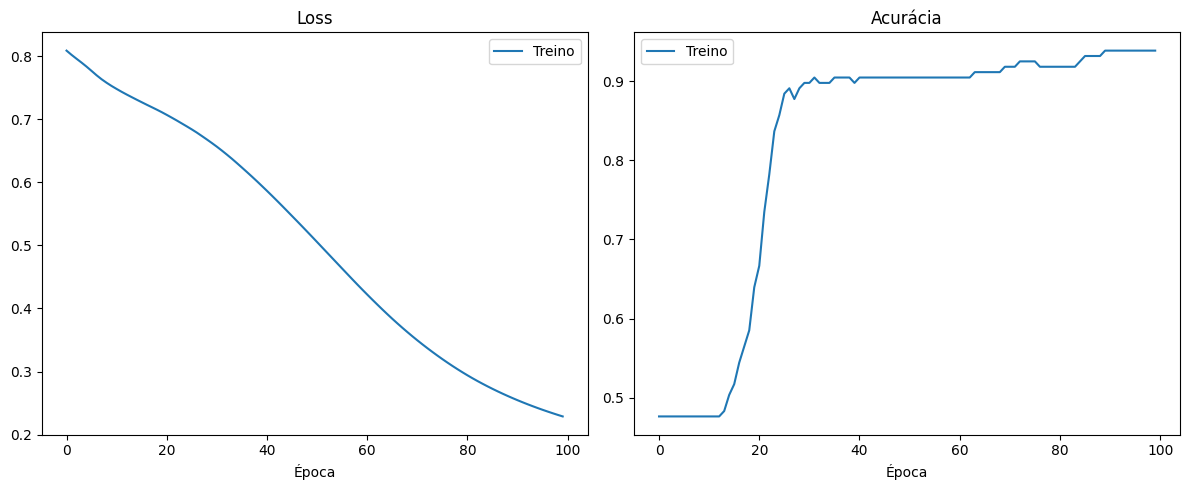

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [122]:
# Dataset de Treinamento
data = np.genfromtxt('C:/aprendizagem-de-maquina/datasets/train_dataset3.csv', delimiter=',', skip_header=1)
X_train = data[:, :-1]  # Features
y_train = data[:, -1]   # Labels
y_train = (y_train + 1) // 2

# Dataset de Teste
data = np.genfromtxt('C:/aprendizagem-de-maquina/datasets/test_dataset3.csv', delimiter=',', skip_header=1)
X_test = data[:, :-1]   # Features
y_test = data[:, -1]    # Labels
y_test = (y_test + 1) // 2

# 1° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='relu')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7398, Acc: 52.38%
Época 10/100 - Loss Treino: 0.6961, Acc: 53.74%
Época 20/100 - Loss Treino: 0.6353, Acc: 73.47%
Época 30/100 - Loss Treino: 0.5584, Acc: 86.39%
Época 40/100 - Loss Treino: 0.4736, Acc: 91.84%
Época 50/100 - Loss Treino: 0.3956, Acc: 91.16%
Época 60/100 - Loss Treino: 0.3342, Acc: 92.52%
Época 70/100 - Loss Treino: 0.2903, Acc: 92.52%
Época 80/100 - Loss Treino: 0.2601, Acc: 93.20%
Época 90/100 - Loss Treino: 0.2393, Acc: 93.88%
Época 100/100 - Loss Treino: 0.2246, Acc: 93.88%
Tempo total de treinamento: 0.30 segundos

Acurácia do Teste: 88.89%


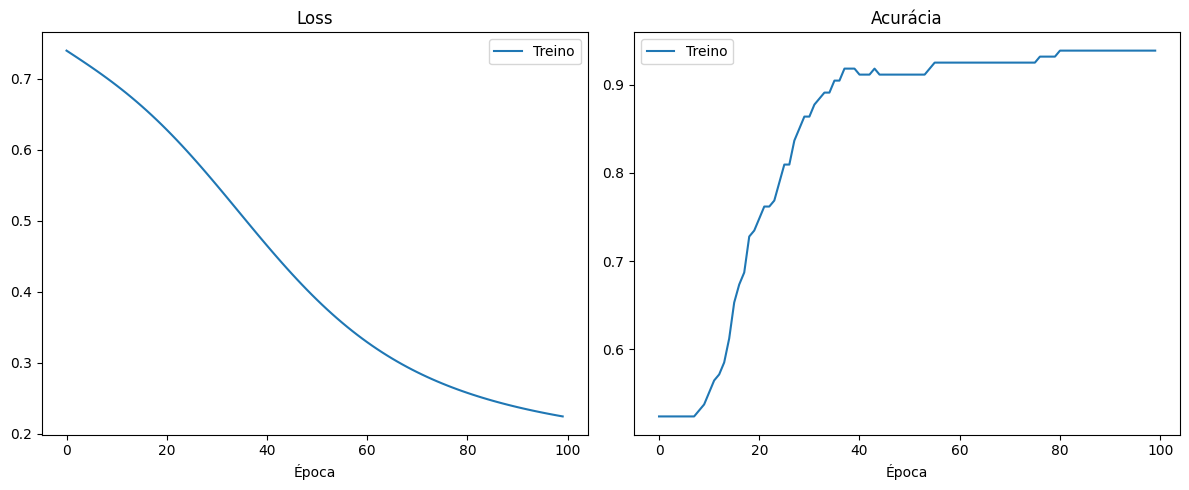

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [123]:
# 2° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='tanh')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7560, Acc: 52.38%
Época 10/100 - Loss Treino: 0.7534, Acc: 52.38%
Época 20/100 - Loss Treino: 0.7537, Acc: 52.38%
Época 30/100 - Loss Treino: 0.7507, Acc: 52.38%
Época 40/100 - Loss Treino: 0.7477, Acc: 52.38%
Época 50/100 - Loss Treino: 0.7452, Acc: 53.74%
Época 60/100 - Loss Treino: 0.7372, Acc: 57.14%
Época 70/100 - Loss Treino: 0.7299, Acc: 65.99%
Época 80/100 - Loss Treino: 0.7179, Acc: 75.51%
Época 90/100 - Loss Treino: 0.7014, Acc: 76.87%
Época 100/100 - Loss Treino: 0.6875, Acc: 78.23%
Tempo total de treinamento: 0.37 segundos

Acurácia do Teste: 80.95%


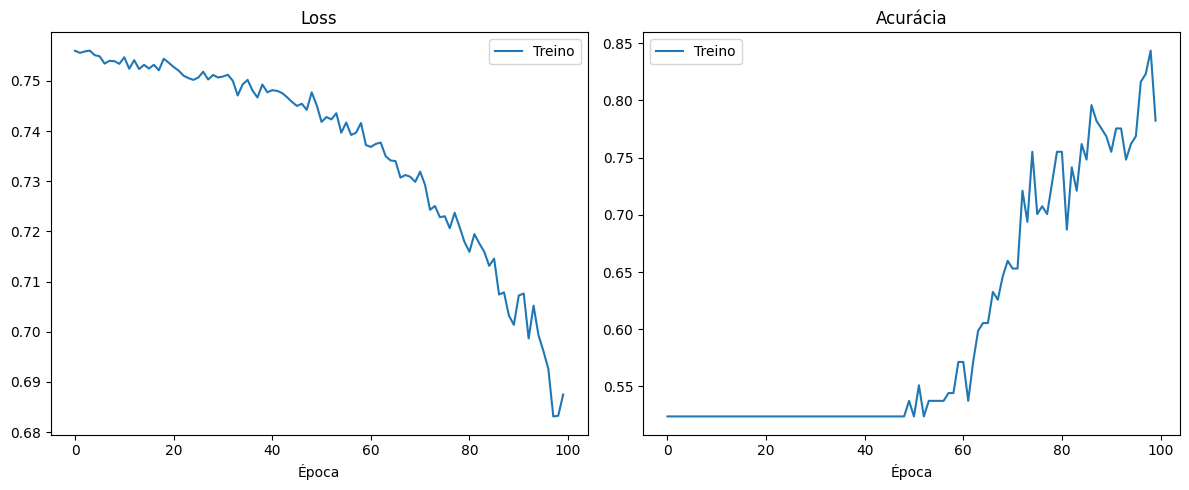

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [124]:
# 3° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7578, Acc: 52.38%
Época 10/100 - Loss Treino: 0.7245, Acc: 56.46%
Época 20/100 - Loss Treino: 0.6777, Acc: 72.11%
Época 30/100 - Loss Treino: 0.6144, Acc: 81.63%
Época 40/100 - Loss Treino: 0.5319, Acc: 91.84%
Época 50/100 - Loss Treino: 0.4626, Acc: 90.48%
Época 60/100 - Loss Treino: 0.3862, Acc: 92.52%
Época 70/100 - Loss Treino: 0.3278, Acc: 93.20%
Época 80/100 - Loss Treino: 0.3077, Acc: 93.20%
Época 90/100 - Loss Treino: 0.2707, Acc: 92.52%
Época 100/100 - Loss Treino: 0.2461, Acc: 93.88%
Tempo total de treinamento: 0.37 segundos

Acurácia do Teste: 88.89%


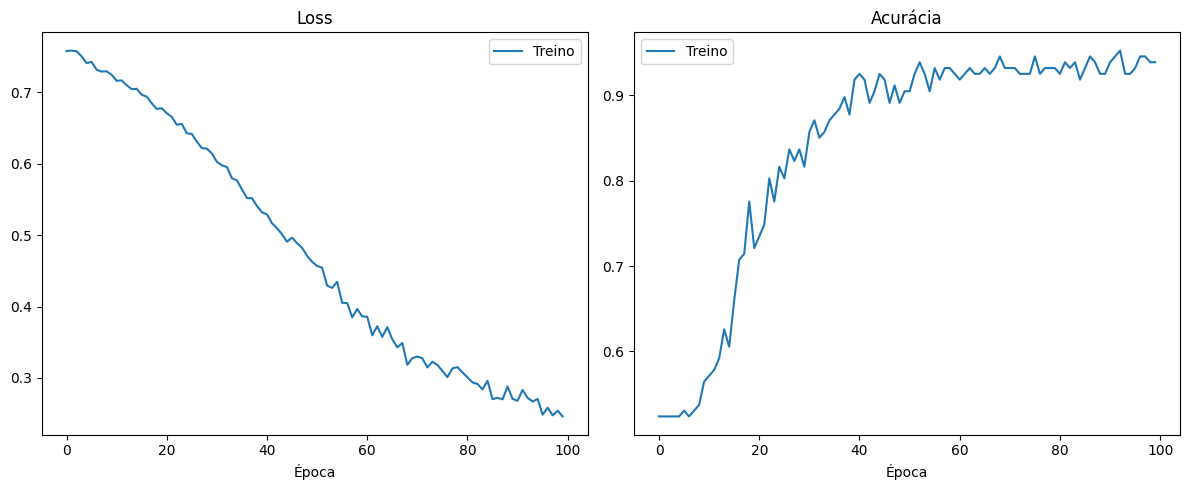

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [125]:
# 4° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7660, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7594, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7538, Acc: 47.62%
Época 30/100 - Loss Treino: 0.7495, Acc: 49.66%
Época 40/100 - Loss Treino: 0.7455, Acc: 67.35%
Época 50/100 - Loss Treino: 0.7415, Acc: 80.95%
Época 60/100 - Loss Treino: 0.7369, Acc: 76.87%
Época 70/100 - Loss Treino: 0.7313, Acc: 74.83%
Época 80/100 - Loss Treino: 0.7239, Acc: 74.83%
Época 90/100 - Loss Treino: 0.7139, Acc: 78.23%
Época 100/100 - Loss Treino: 0.7002, Acc: 80.95%
Tempo total de treinamento: 0.29 segundos

Acurácia do Teste: 74.60%


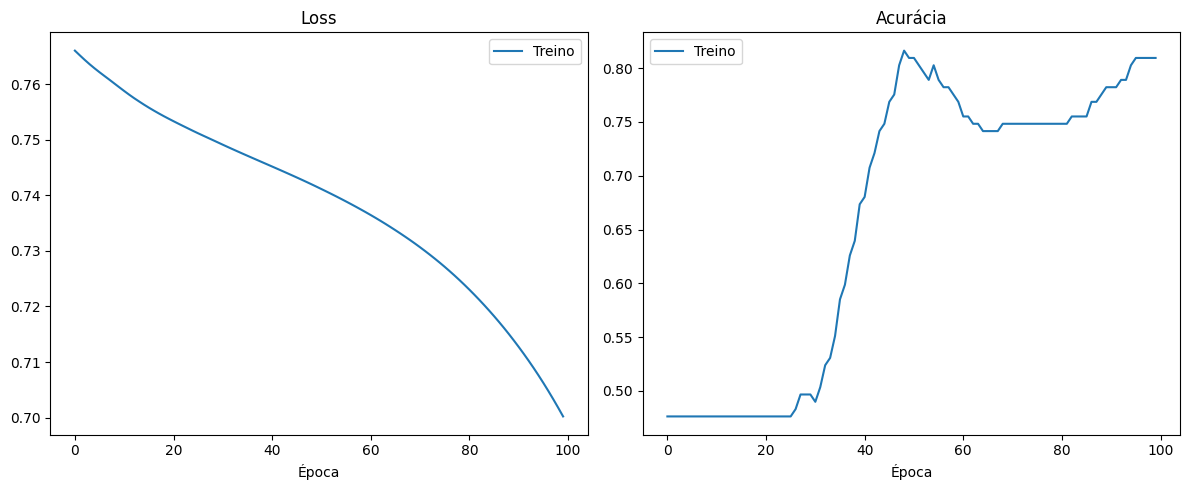

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [126]:
# 5° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='relu',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.8184, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7423, Acc: 47.62%
Época 20/100 - Loss Treino: 0.6605, Acc: 76.19%
Época 30/100 - Loss Treino: 0.5649, Acc: 91.84%
Época 40/100 - Loss Treino: 0.4631, Acc: 92.52%
Época 50/100 - Loss Treino: 0.3764, Acc: 92.52%
Época 60/100 - Loss Treino: 0.3152, Acc: 92.52%
Época 70/100 - Loss Treino: 0.2759, Acc: 92.52%
Época 80/100 - Loss Treino: 0.2511, Acc: 92.52%
Época 90/100 - Loss Treino: 0.2346, Acc: 92.52%
Época 100/100 - Loss Treino: 0.2230, Acc: 93.20%
Tempo total de treinamento: 0.29 segundos

Acurácia do Teste: 87.30%


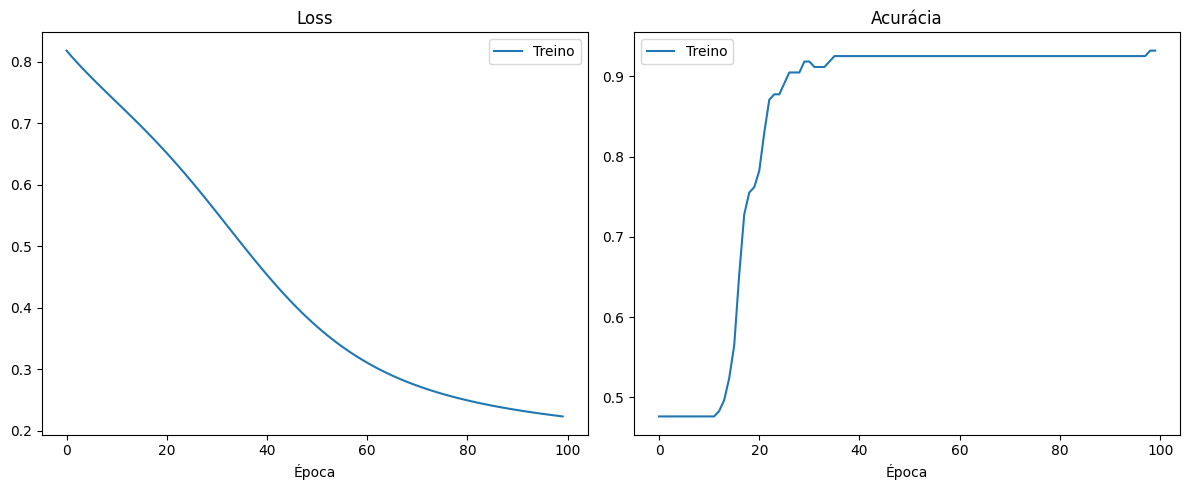

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [127]:
# 6° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,64,4],
                    activation='tanh',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7780, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7677, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7596, Acc: 47.62%
Época 30/100 - Loss Treino: 0.7566, Acc: 47.62%
Época 40/100 - Loss Treino: 0.7546, Acc: 47.62%
Época 50/100 - Loss Treino: 0.7532, Acc: 47.62%
Época 60/100 - Loss Treino: 0.7520, Acc: 64.63%
Época 70/100 - Loss Treino: 0.7510, Acc: 65.31%
Época 80/100 - Loss Treino: 0.7500, Acc: 58.50%
Época 90/100 - Loss Treino: 0.7491, Acc: 53.06%
Época 100/100 - Loss Treino: 0.7480, Acc: 53.06%
Tempo total de treinamento: 0.35 segundos

Acurácia do Teste: 47.62%


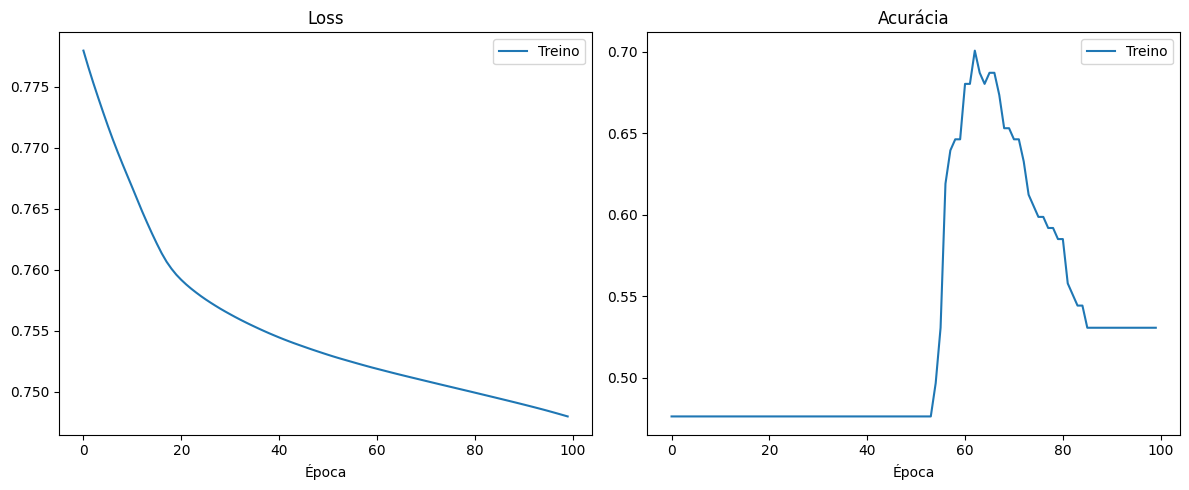

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [128]:
# 7° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='relu')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7292, Acc: 56.46%
Época 10/100 - Loss Treino: 0.6233, Acc: 87.07%
Época 20/100 - Loss Treino: 0.4972, Acc: 90.48%
Época 30/100 - Loss Treino: 0.3835, Acc: 93.88%
Época 40/100 - Loss Treino: 0.3076, Acc: 93.88%
Época 50/100 - Loss Treino: 0.2638, Acc: 93.88%
Época 60/100 - Loss Treino: 0.2381, Acc: 93.20%
Época 70/100 - Loss Treino: 0.2219, Acc: 93.88%
Época 80/100 - Loss Treino: 0.2108, Acc: 93.88%
Época 90/100 - Loss Treino: 0.2025, Acc: 93.88%
Época 100/100 - Loss Treino: 0.1961, Acc: 93.88%
Tempo total de treinamento: 0.35 segundos

Acurácia do Teste: 85.71%


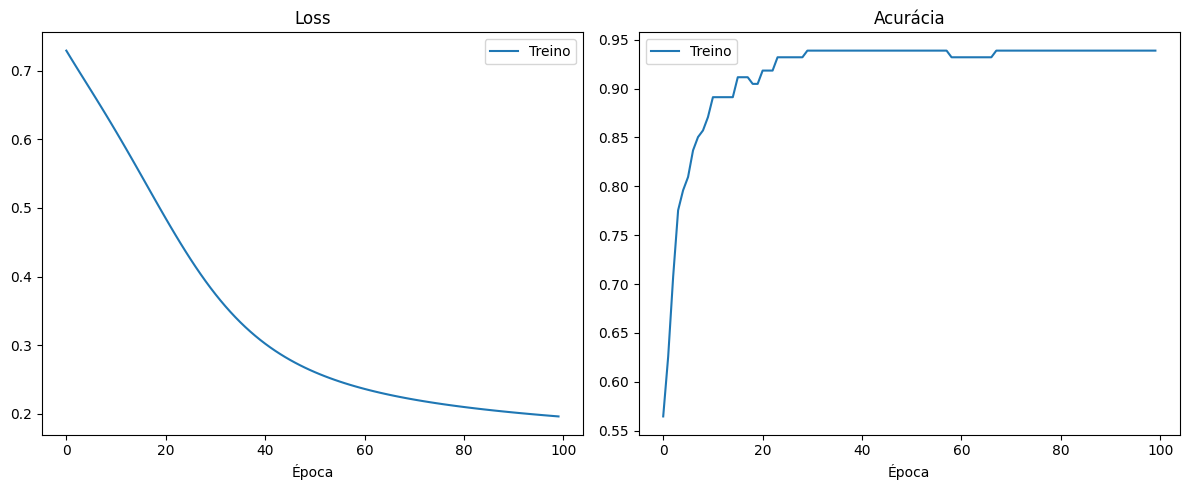

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [129]:
# 8° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='tanh')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

In [ ]:
# 9° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7577, Acc: 53.74%
Época 10/100 - Loss Treino: 0.7188, Acc: 64.63%
Época 20/100 - Loss Treino: 0.6678, Acc: 78.91%
Época 30/100 - Loss Treino: 0.6003, Acc: 82.99%
Época 40/100 - Loss Treino: 0.5028, Acc: 87.76%
Época 50/100 - Loss Treino: 0.4151, Acc: 91.16%
Época 60/100 - Loss Treino: 0.3454, Acc: 91.84%
Época 70/100 - Loss Treino: 0.2977, Acc: 91.16%
Época 80/100 - Loss Treino: 0.2777, Acc: 92.52%
Época 90/100 - Loss Treino: 0.2389, Acc: 93.88%
Época 100/100 - Loss Treino: 0.2452, Acc: 93.20%
Tempo total de treinamento: 0.50 segundos

Acurácia do Teste: 84.13%


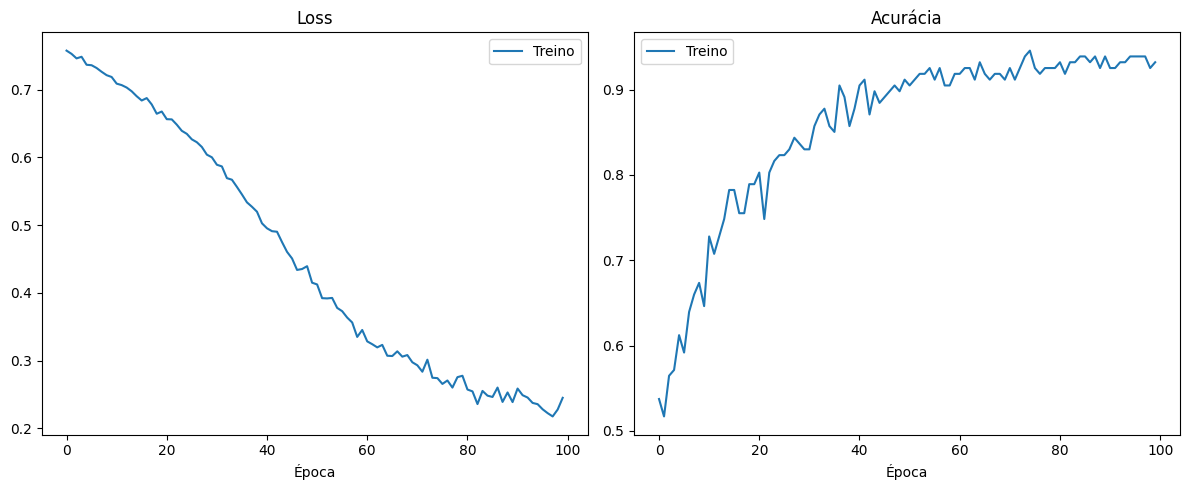

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 10° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7622, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7575, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7527, Acc: 47.62%
Época 30/100 - Loss Treino: 0.7484, Acc: 47.62%
Época 40/100 - Loss Treino: 0.7440, Acc: 60.54%
Época 50/100 - Loss Treino: 0.7394, Acc: 77.55%
Época 60/100 - Loss Treino: 0.7340, Acc: 80.95%
Época 70/100 - Loss Treino: 0.7273, Acc: 81.63%
Época 80/100 - Loss Treino: 0.7188, Acc: 82.99%
Época 90/100 - Loss Treino: 0.7073, Acc: 84.35%
Época 100/100 - Loss Treino: 0.6917, Acc: 87.76%
Tempo total de treinamento: 0.37 segundos

Acurácia do Teste: 80.95%


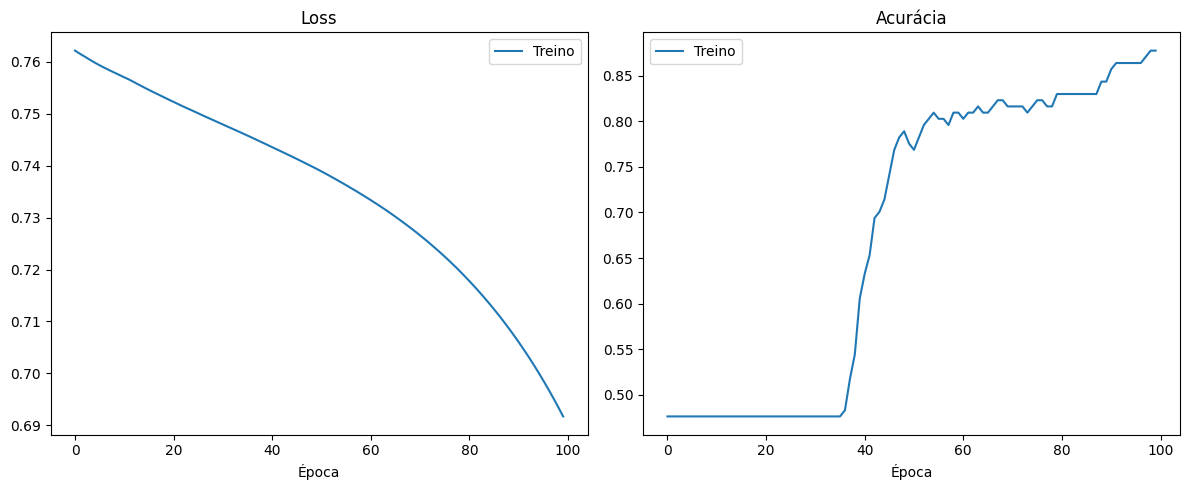

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 11° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='relu',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7247, Acc: 70.07%
Época 10/100 - Loss Treino: 0.6520, Acc: 91.84%
Época 20/100 - Loss Treino: 0.5504, Acc: 91.84%
Época 30/100 - Loss Treino: 0.4359, Acc: 92.52%
Época 40/100 - Loss Treino: 0.3439, Acc: 93.20%
Época 50/100 - Loss Treino: 0.2867, Acc: 93.20%
Época 60/100 - Loss Treino: 0.2535, Acc: 93.20%
Época 70/100 - Loss Treino: 0.2331, Acc: 93.20%
Época 80/100 - Loss Treino: 0.2194, Acc: 93.88%
Época 90/100 - Loss Treino: 0.2095, Acc: 93.88%
Época 100/100 - Loss Treino: 0.2018, Acc: 93.88%
Tempo total de treinamento: 0.38 segundos

Acurácia do Teste: 88.89%


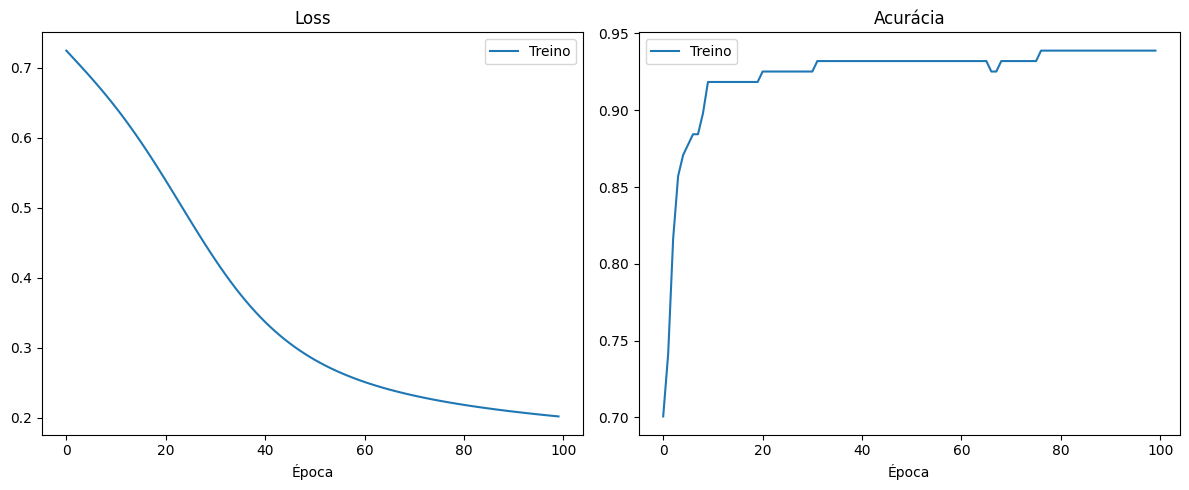

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 12° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,128,64,4],
                    activation='tanh',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7582, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7554, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7539, Acc: 57.14%
Época 30/100 - Loss Treino: 0.7523, Acc: 55.78%
Época 40/100 - Loss Treino: 0.7507, Acc: 55.10%
Época 50/100 - Loss Treino: 0.7490, Acc: 54.42%
Época 60/100 - Loss Treino: 0.7471, Acc: 54.42%
Época 70/100 - Loss Treino: 0.7449, Acc: 55.10%
Época 80/100 - Loss Treino: 0.7424, Acc: 57.14%
Época 90/100 - Loss Treino: 0.7394, Acc: 64.63%
Época 100/100 - Loss Treino: 0.7357, Acc: 72.79%
Tempo total de treinamento: 0.44 segundos

Acurácia do Teste: 71.43%


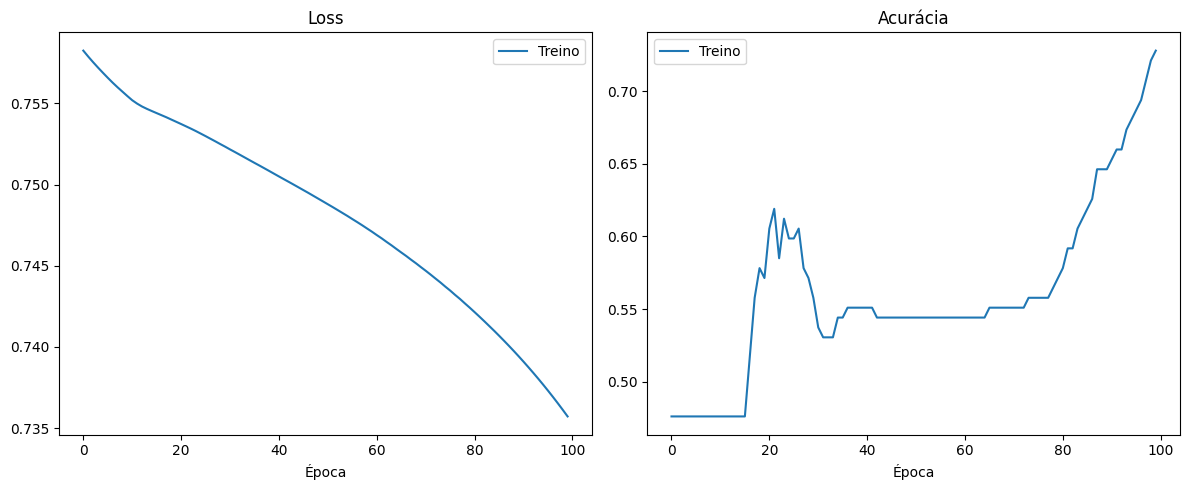

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 13° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7564, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7315, Acc: 54.42%
Época 20/100 - Loss Treino: 0.6969, Acc: 85.03%
Época 30/100 - Loss Treino: 0.6419, Acc: 87.76%
Época 40/100 - Loss Treino: 0.5558, Acc: 88.44%
Época 50/100 - Loss Treino: 0.4532, Acc: 89.80%
Época 60/100 - Loss Treino: 0.3666, Acc: 91.16%
Época 70/100 - Loss Treino: 0.3077, Acc: 91.84%
Época 80/100 - Loss Treino: 0.2699, Acc: 92.52%
Época 90/100 - Loss Treino: 0.2447, Acc: 93.20%
Época 100/100 - Loss Treino: 0.2273, Acc: 94.56%
Tempo total de treinamento: 0.45 segundos

Acurácia do Teste: 88.89%


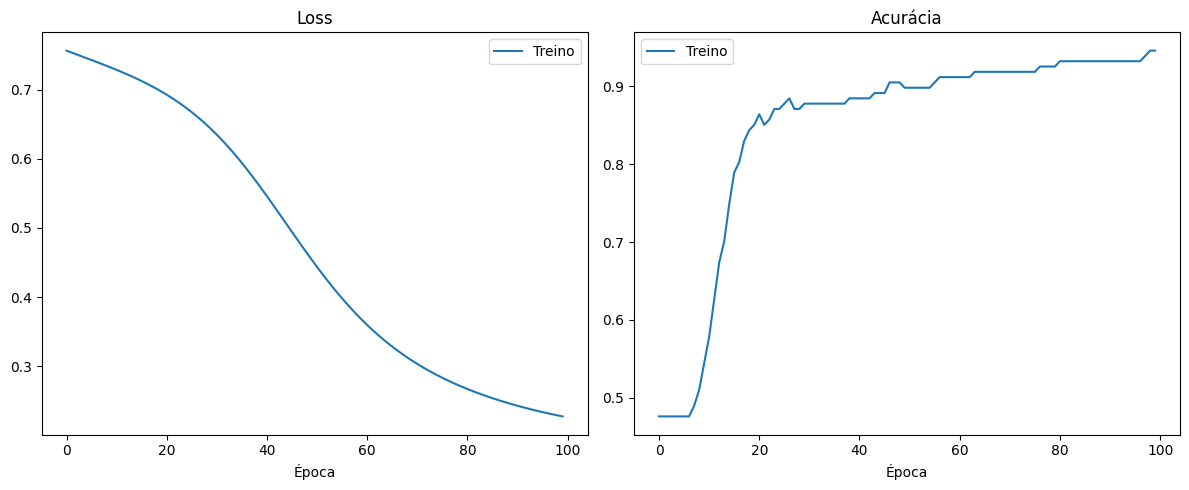

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 14° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7780, Acc: 52.38%
Época 10/100 - Loss Treino: 0.7695, Acc: 52.38%
Época 20/100 - Loss Treino: 0.7631, Acc: 52.38%
Época 30/100 - Loss Treino: 0.7599, Acc: 52.38%
Época 40/100 - Loss Treino: 0.7573, Acc: 52.38%
Época 50/100 - Loss Treino: 0.7558, Acc: 52.38%
Época 60/100 - Loss Treino: 0.7552, Acc: 52.38%
Época 70/100 - Loss Treino: 0.7542, Acc: 52.38%
Época 80/100 - Loss Treino: 0.7544, Acc: 52.38%
Época 90/100 - Loss Treino: 0.7540, Acc: 52.38%
Época 100/100 - Loss Treino: 0.7538, Acc: 52.38%
Tempo total de treinamento: 0.60 segundos

Acurácia do Teste: 46.03%


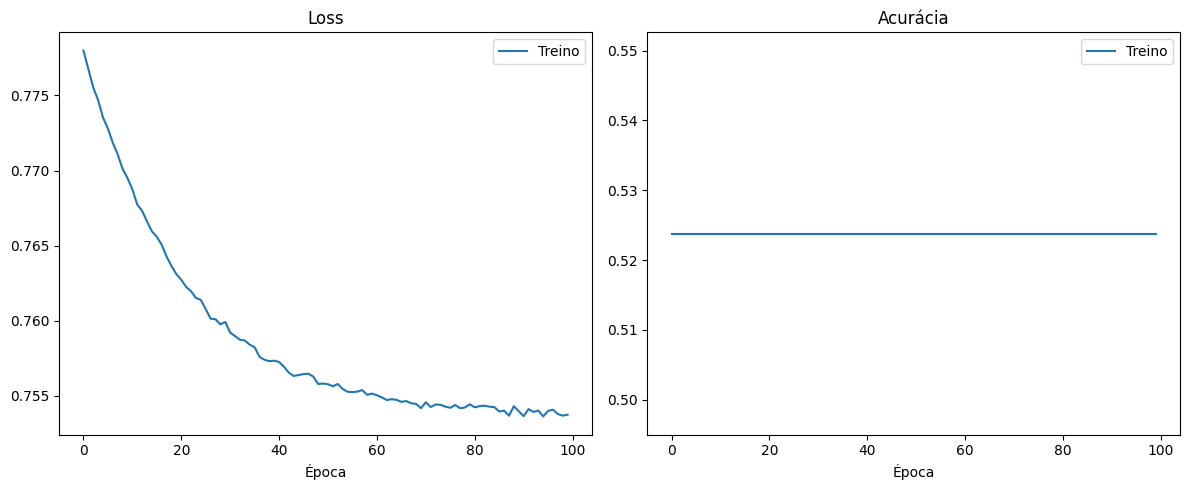

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 15° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7831, Acc: 47.62%
Época 10/100 - Loss Treino: 0.7515, Acc: 47.62%
Época 20/100 - Loss Treino: 0.7137, Acc: 61.90%
Época 30/100 - Loss Treino: 0.6732, Acc: 84.35%
Época 40/100 - Loss Treino: 0.6042, Acc: 85.71%
Época 50/100 - Loss Treino: 0.5199, Acc: 89.12%
Época 60/100 - Loss Treino: 0.4028, Acc: 91.84%
Época 70/100 - Loss Treino: 0.3382, Acc: 91.84%
Época 80/100 - Loss Treino: 0.2935, Acc: 94.56%
Época 90/100 - Loss Treino: 0.2600, Acc: 93.20%
Época 100/100 - Loss Treino: 0.2434, Acc: 94.56%
Tempo total de treinamento: 0.60 segundos

Acurácia do Teste: 88.89%


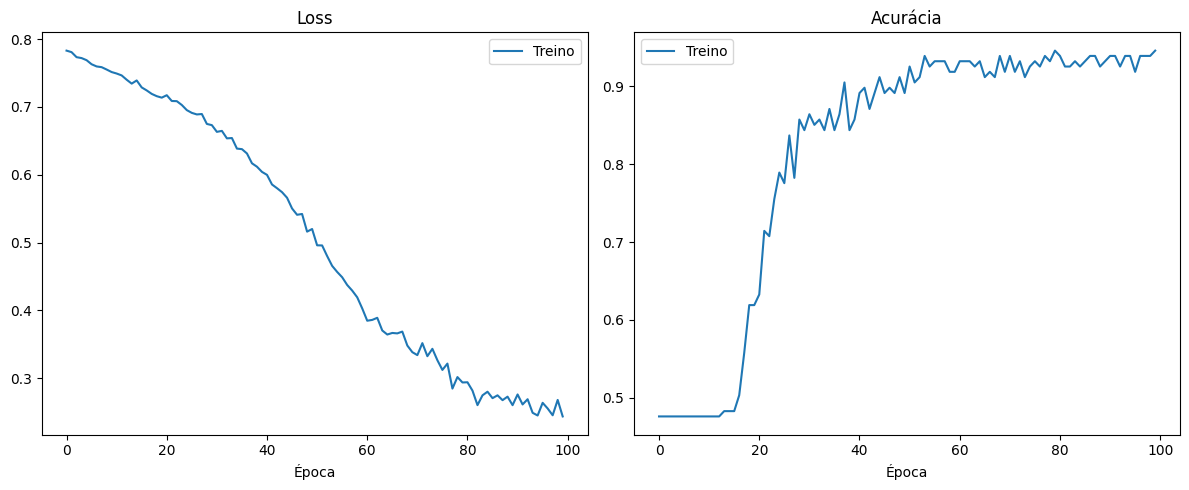

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 16° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7638, Acc: 52.38%
Época 10/100 - Loss Treino: 0.7576, Acc: 52.38%
Época 20/100 - Loss Treino: 0.7533, Acc: 52.38%
Época 30/100 - Loss Treino: 0.7503, Acc: 52.38%
Época 40/100 - Loss Treino: 0.7476, Acc: 52.38%
Época 50/100 - Loss Treino: 0.7448, Acc: 52.38%
Época 60/100 - Loss Treino: 0.7416, Acc: 52.38%
Época 70/100 - Loss Treino: 0.7377, Acc: 52.38%
Época 80/100 - Loss Treino: 0.7327, Acc: 52.38%
Época 90/100 - Loss Treino: 0.7261, Acc: 56.46%
Época 100/100 - Loss Treino: 0.7172, Acc: 69.39%
Tempo total de treinamento: 0.43 segundos

Acurácia do Teste: 61.90%


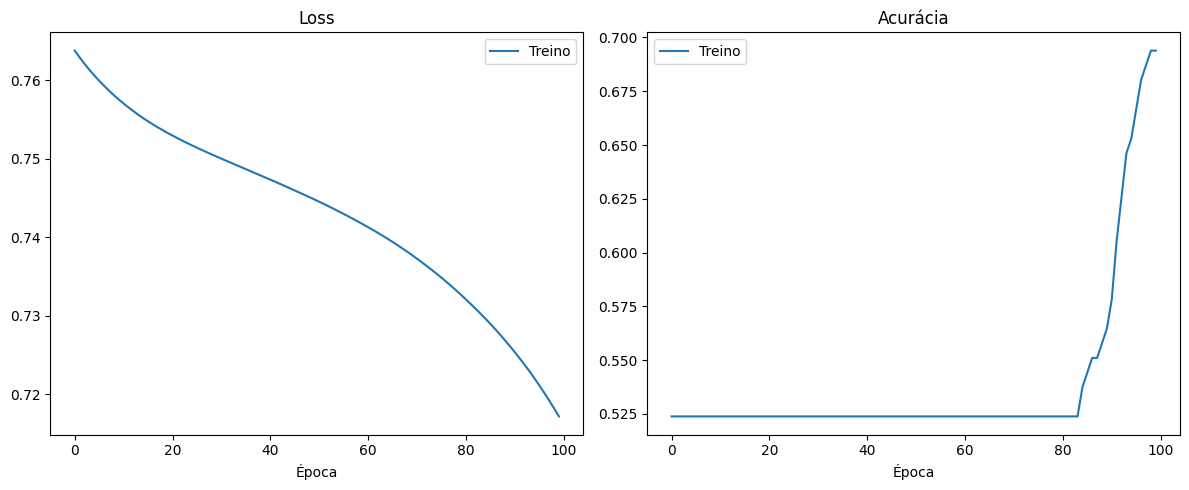

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 17° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu',
                    regularization='l2',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7486, Acc: 51.02%
Época 10/100 - Loss Treino: 0.7156, Acc: 82.99%
Época 20/100 - Loss Treino: 0.6662, Acc: 87.07%
Época 30/100 - Loss Treino: 0.5910, Acc: 87.07%
Época 40/100 - Loss Treino: 0.4947, Acc: 89.80%
Época 50/100 - Loss Treino: 0.4032, Acc: 91.84%
Época 60/100 - Loss Treino: 0.3347, Acc: 92.52%
Época 70/100 - Loss Treino: 0.2901, Acc: 93.88%
Época 80/100 - Loss Treino: 0.2621, Acc: 93.88%
Época 90/100 - Loss Treino: 0.2438, Acc: 93.88%
Época 100/100 - Loss Treino: 0.2313, Acc: 93.88%
Tempo total de treinamento: 0.45 segundos

Acurácia do Teste: 85.71%


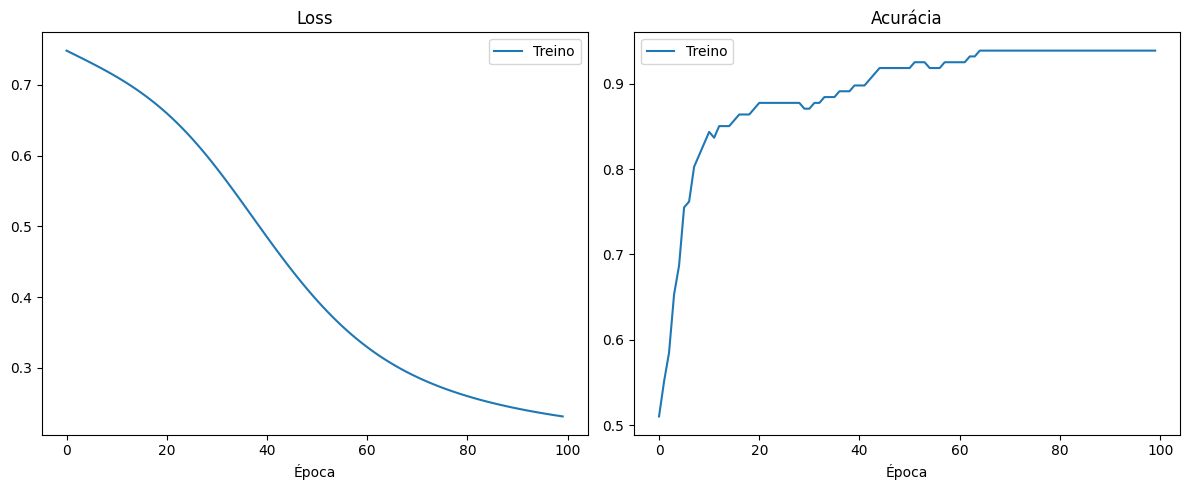

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 18° Caso
mlp = MLPClassifier(optimizer='sgd',
                    learning_rate=0.01,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh',
                    regularization='l2',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7514, Acc: 52.38%


Época 10/100 - Loss Treino: 0.3905, Acc: 92.52%
Época 20/100 - Loss Treino: 0.1664, Acc: 93.88%
Época 30/100 - Loss Treino: 0.1172, Acc: 95.24%
Época 40/100 - Loss Treino: 0.0805, Acc: 97.28%
Época 50/100 - Loss Treino: 0.0554, Acc: 97.96%
Época 60/100 - Loss Treino: 0.0375, Acc: 99.32%
Época 70/100 - Loss Treino: 0.0244, Acc: 99.32%
Época 80/100 - Loss Treino: 0.0156, Acc: 99.32%
Época 90/100 - Loss Treino: 0.0118, Acc: 99.32%
Época 100/100 - Loss Treino: 0.0097, Acc: 99.32%
Tempo total de treinamento: 0.48 segundos

Acurácia do Teste: 87.30%


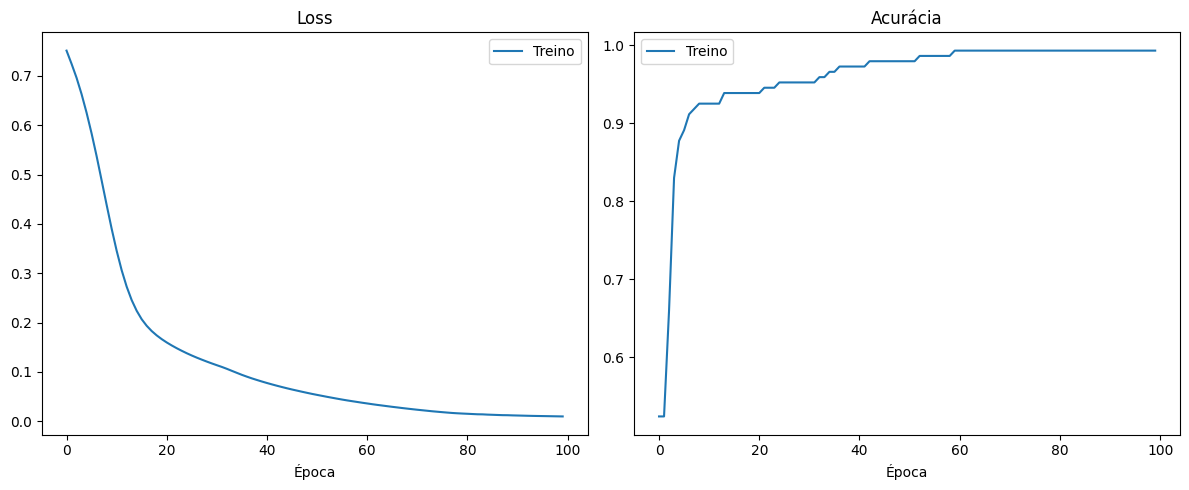

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 19° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='relu')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7435, Acc: 55.78%
Época 10/100 - Loss Treino: 0.3934, Acc: 91.16%
Época 20/100 - Loss Treino: 0.2698, Acc: 94.56%
Época 30/100 - Loss Treino: 0.2258, Acc: 95.92%
Época 40/100 - Loss Treino: 0.1969, Acc: 95.24%
Época 50/100 - Loss Treino: 0.1680, Acc: 97.28%
Época 60/100 - Loss Treino: 0.1442, Acc: 97.28%
Época 70/100 - Loss Treino: 0.1265, Acc: 97.28%
Época 80/100 - Loss Treino: 0.1131, Acc: 97.96%
Época 90/100 - Loss Treino: 0.1018, Acc: 97.96%
Época 100/100 - Loss Treino: 0.0916, Acc: 98.64%
Tempo total de treinamento: 0.50 segundos

Acurácia do Teste: 85.71%


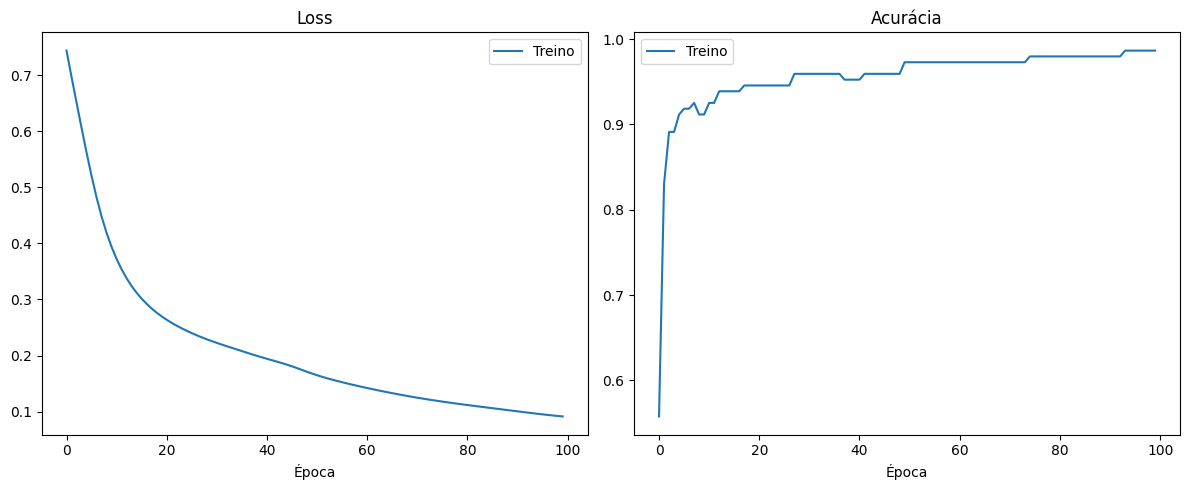

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 20° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='tanh')

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7524, Acc: 52.38%
Época 10/100 - Loss Treino: 0.5038, Acc: 90.48%
Época 20/100 - Loss Treino: 0.1762, Acc: 94.56%
Época 30/100 - Loss Treino: 0.1960, Acc: 95.92%
Época 40/100 - Loss Treino: 0.1452, Acc: 96.60%
Época 50/100 - Loss Treino: 0.1343, Acc: 95.92%
Época 60/100 - Loss Treino: 0.1320, Acc: 97.28%
Época 70/100 - Loss Treino: 0.0963, Acc: 96.60%
Época 80/100 - Loss Treino: 0.0950, Acc: 96.60%
Época 90/100 - Loss Treino: 0.0887, Acc: 95.92%
Época 100/100 - Loss Treino: 0.0577, Acc: 97.96%
Tempo total de treinamento: 0.55 segundos

Acurácia do Teste: 87.30%


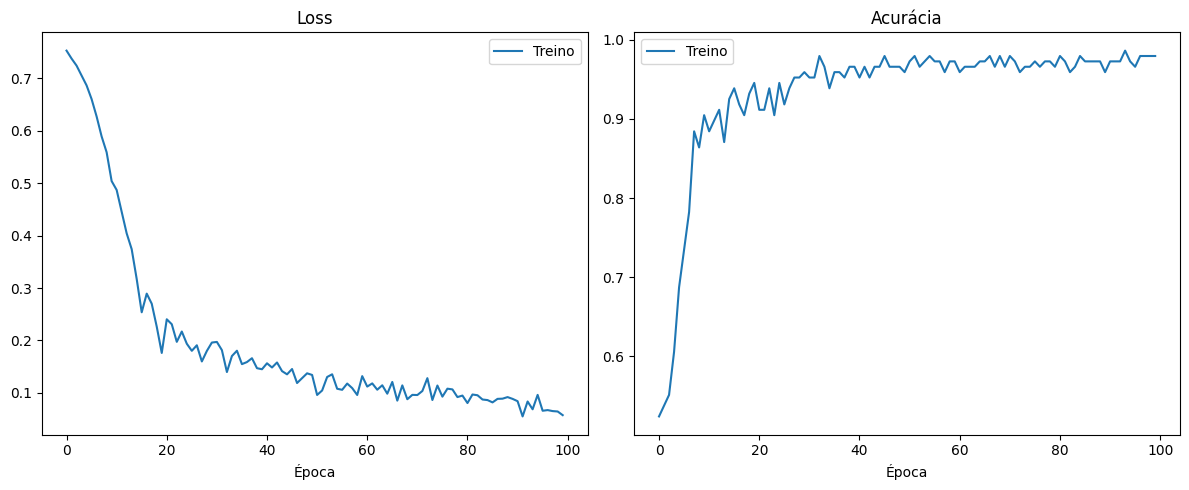

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 21° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7545, Acc: 53.06%
Época 10/100 - Loss Treino: 0.3947, Acc: 93.88%
Época 20/100 - Loss Treino: 0.2849, Acc: 94.56%
Época 30/100 - Loss Treino: 0.2359, Acc: 95.24%
Época 40/100 - Loss Treino: 0.2269, Acc: 95.24%
Época 50/100 - Loss Treino: 0.1766, Acc: 95.92%
Época 60/100 - Loss Treino: 0.1948, Acc: 95.92%
Época 70/100 - Loss Treino: 0.1881, Acc: 96.60%
Época 80/100 - Loss Treino: 0.1861, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1625, Acc: 96.60%
Época 100/100 - Loss Treino: 0.1857, Acc: 95.92%
Tempo total de treinamento: 0.62 segundos

Acurácia do Teste: 84.13%


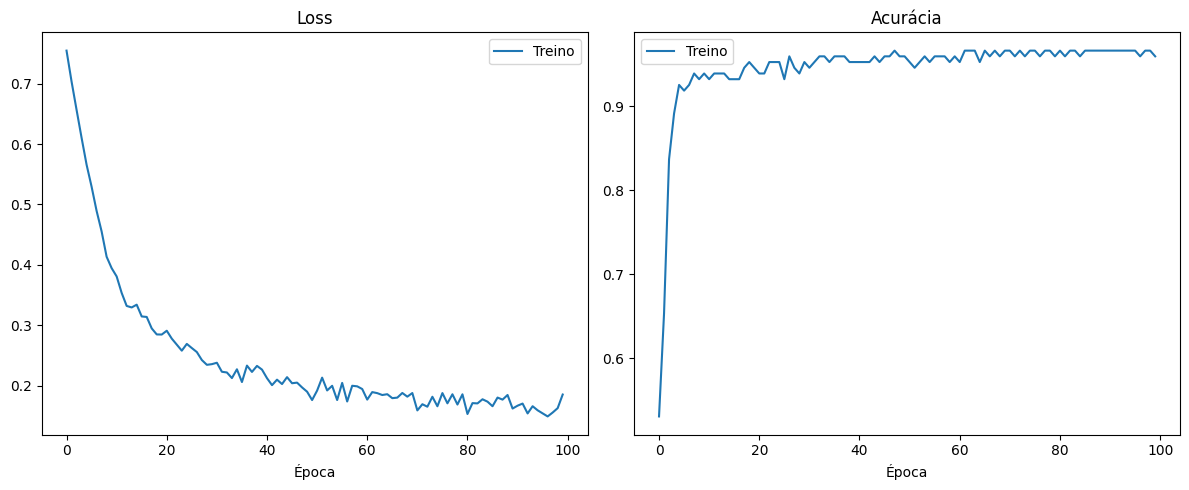

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 22° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7487, Acc: 52.38%
Época 10/100 - Loss Treino: 0.4616, Acc: 92.52%
Época 20/100 - Loss Treino: 0.1766, Acc: 94.56%
Época 30/100 - Loss Treino: 0.1276, Acc: 95.24%
Época 40/100 - Loss Treino: 0.0929, Acc: 97.28%
Época 50/100 - Loss Treino: 0.0709, Acc: 97.28%
Época 60/100 - Loss Treino: 0.0533, Acc: 97.96%
Época 70/100 - Loss Treino: 0.0391, Acc: 98.64%
Época 80/100 - Loss Treino: 0.0281, Acc: 99.32%
Época 90/100 - Loss Treino: 0.0206, Acc: 99.32%
Época 100/100 - Loss Treino: 0.0158, Acc: 99.32%
Tempo total de treinamento: 0.52 segundos

Acurácia do Teste: 85.71%


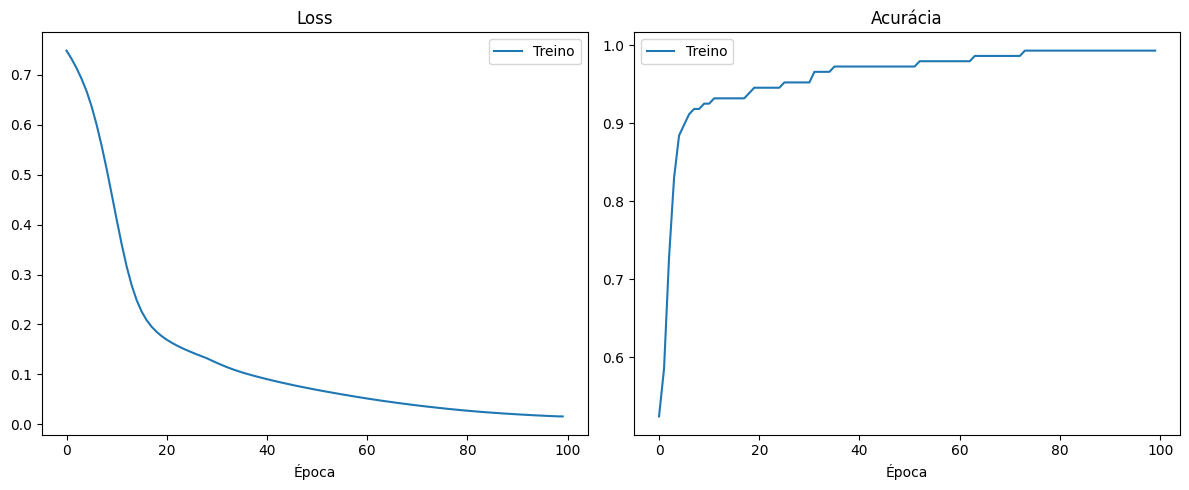

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 23° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='relu',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7830, Acc: 47.62%
Época 10/100 - Loss Treino: 0.2855, Acc: 93.88%
Época 20/100 - Loss Treino: 0.2144, Acc: 93.20%
Época 30/100 - Loss Treino: 0.1894, Acc: 94.56%
Época 40/100 - Loss Treino: 0.1734, Acc: 94.56%
Época 50/100 - Loss Treino: 0.1598, Acc: 94.56%
Época 60/100 - Loss Treino: 0.1471, Acc: 96.60%
Época 70/100 - Loss Treino: 0.1345, Acc: 96.60%
Época 80/100 - Loss Treino: 0.1240, Acc: 97.96%
Época 90/100 - Loss Treino: 0.1162, Acc: 97.96%
Época 100/100 - Loss Treino: 0.1106, Acc: 97.96%
Tempo total de treinamento: 0.52 segundos

Acurácia do Teste: 84.13%


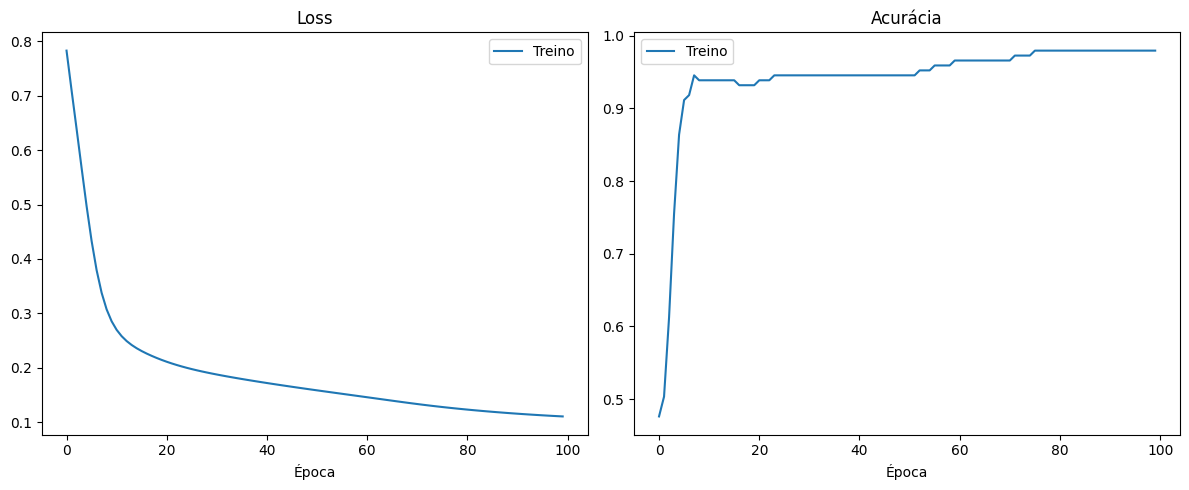

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 24° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,64,4],
                    activation='tanh',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7509, Acc: 52.38%
Época 10/100 - Loss Treino: 0.3964, Acc: 93.20%
Época 20/100 - Loss Treino: 0.3139, Acc: 97.28%
Época 30/100 - Loss Treino: 0.2756, Acc: 97.96%
Época 40/100 - Loss Treino: 0.2483, Acc: 98.64%
Época 50/100 - Loss Treino: 0.2297, Acc: 98.64%
Época 60/100 - Loss Treino: 0.2145, Acc: 98.64%
Época 70/100 - Loss Treino: 0.2010, Acc: 98.64%
Época 80/100 - Loss Treino: 0.1890, Acc: 98.64%
Época 90/100 - Loss Treino: 0.1783, Acc: 98.64%
Época 100/100 - Loss Treino: 0.1687, Acc: 98.64%
Tempo total de treinamento: 0.61 segundos

Acurácia do Teste: 82.54%


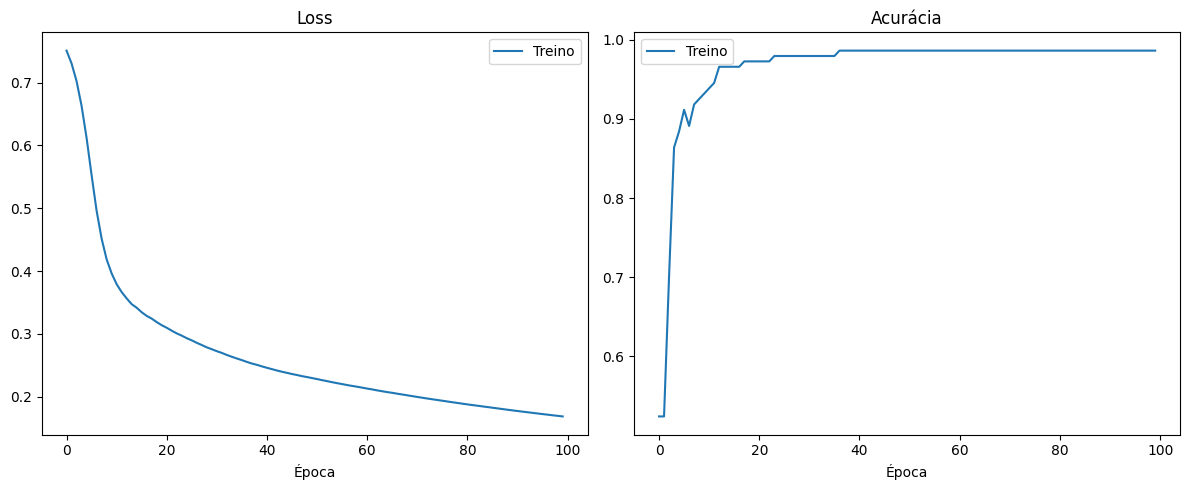

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 25° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4],
                    activation='relu',)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7239, Acc: 69.39%
Época 10/100 - Loss Treino: 0.3366, Acc: 93.88%
Época 20/100 - Loss Treino: 0.2516, Acc: 95.92%
Época 30/100 - Loss Treino: 0.2136, Acc: 95.92%
Época 40/100 - Loss Treino: 0.1961, Acc: 95.92%
Época 50/100 - Loss Treino: 0.1866, Acc: 95.92%
Época 60/100 - Loss Treino: 0.1811, Acc: 95.92%
Época 70/100 - Loss Treino: 0.1778, Acc: 95.92%
Época 80/100 - Loss Treino: 0.1757, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1744, Acc: 95.92%
Época 100/100 - Loss Treino: 0.1736, Acc: 95.92%
Tempo total de treinamento: 0.58 segundos

Acurácia do Teste: 84.13%


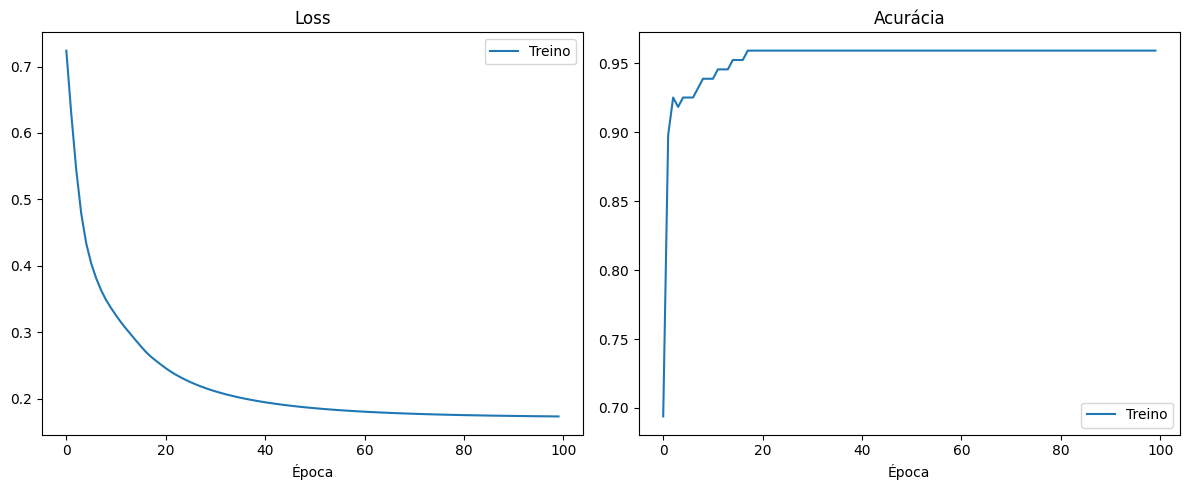

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 26° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4,],
                    activation='tanh',)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7771, Acc: 47.62%
Época 10/100 - Loss Treino: 0.3574, Acc: 91.16%
Época 20/100 - Loss Treino: 0.1721, Acc: 94.56%
Época 30/100 - Loss Treino: 0.1349, Acc: 97.28%
Época 40/100 - Loss Treino: 0.1183, Acc: 95.24%
Época 50/100 - Loss Treino: 0.0963, Acc: 96.60%
Época 60/100 - Loss Treino: 0.0708, Acc: 97.28%
Época 70/100 - Loss Treino: 0.0766, Acc: 98.64%
Época 80/100 - Loss Treino: 0.0276, Acc: 99.32%
Época 90/100 - Loss Treino: 0.0135, Acc: 100.00%
Época 100/100 - Loss Treino: 0.0279, Acc: 98.64%
Tempo total de treinamento: 0.71 segundos

Acurácia do Teste: 82.54%


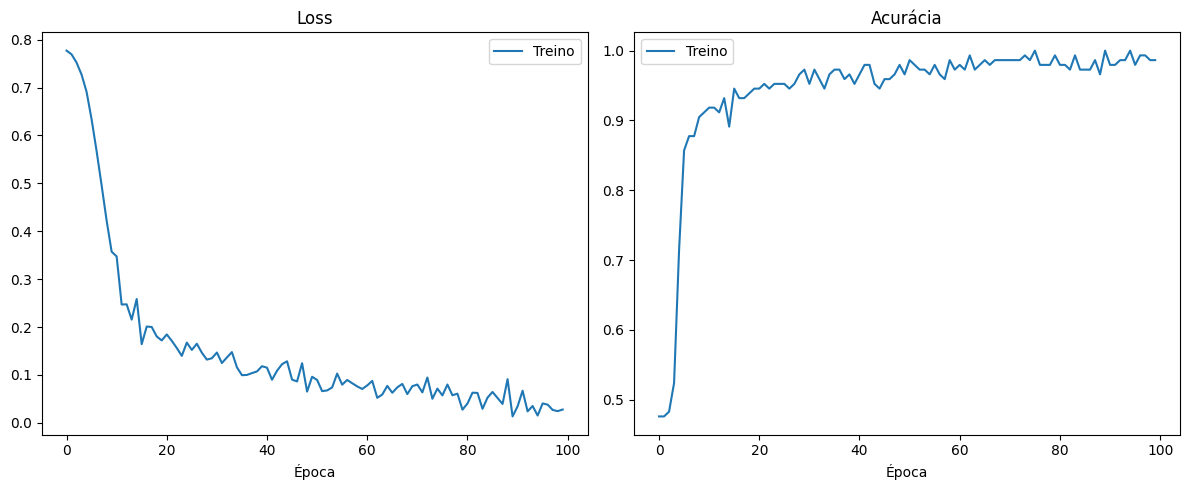

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 27° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7406, Acc: 48.30%
Época 10/100 - Loss Treino: 0.3591, Acc: 91.16%
Época 20/100 - Loss Treino: 0.2773, Acc: 94.56%
Época 30/100 - Loss Treino: 0.2383, Acc: 95.24%
Época 40/100 - Loss Treino: 0.2268, Acc: 95.24%
Época 50/100 - Loss Treino: 0.1881, Acc: 95.92%
Época 60/100 - Loss Treino: 0.2009, Acc: 95.24%
Época 70/100 - Loss Treino: 0.2129, Acc: 95.24%
Época 80/100 - Loss Treino: 0.1924, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1988, Acc: 95.24%
Época 100/100 - Loss Treino: 0.1809, Acc: 95.92%
Tempo total de treinamento: 0.70 segundos

Acurácia do Teste: 85.71%


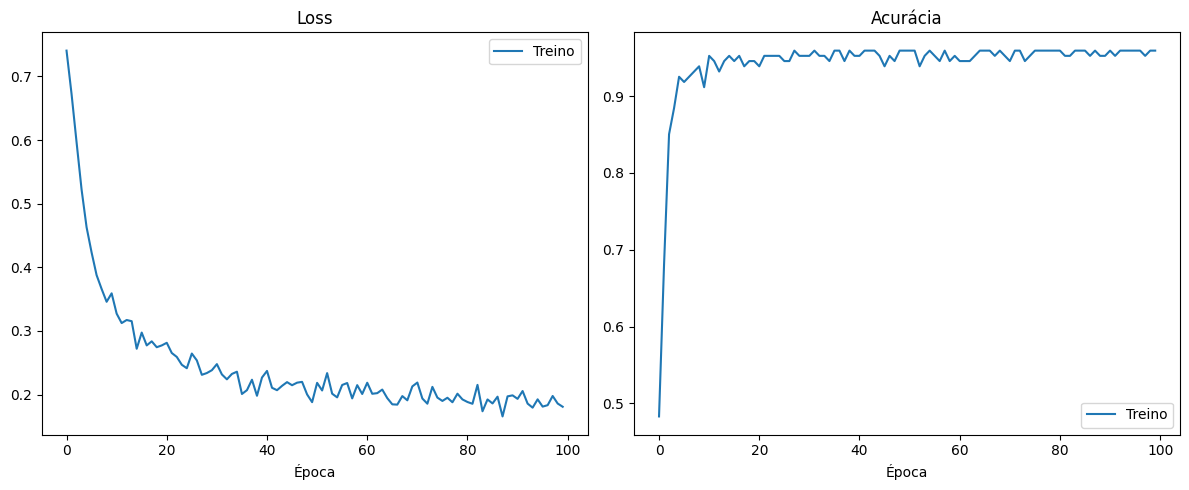

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 28° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7412, Acc: 52.38%
Época 10/100 - Loss Treino: 0.3838, Acc: 94.56%
Época 20/100 - Loss Treino: 0.1125, Acc: 97.28%
Época 30/100 - Loss Treino: 0.0748, Acc: 97.96%
Época 40/100 - Loss Treino: 0.0518, Acc: 98.64%
Época 50/100 - Loss Treino: 0.0360, Acc: 99.32%
Época 60/100 - Loss Treino: 0.0254, Acc: 99.32%
Época 70/100 - Loss Treino: 0.0174, Acc: 99.32%
Época 80/100 - Loss Treino: 0.0122, Acc: 99.32%
Época 90/100 - Loss Treino: 0.0108, Acc: 99.32%
Época 100/100 - Loss Treino: 0.0102, Acc: 99.32%
Tempo total de treinamento: 0.57 segundos

Acurácia do Teste: 85.71%


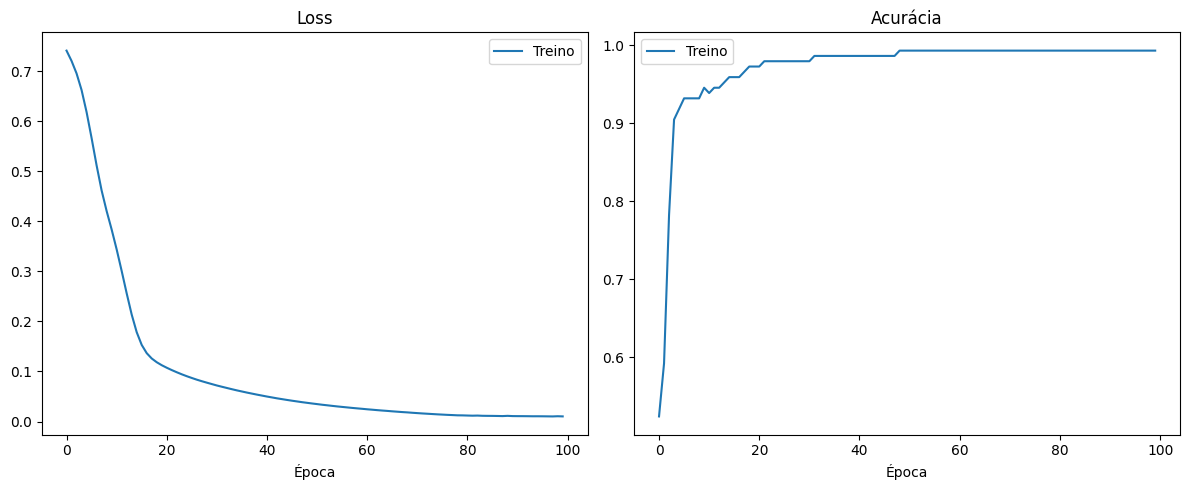

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 29° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4],
                    activation='relu',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7050, Acc: 61.22%
Época 10/100 - Loss Treino: 0.2609, Acc: 95.24%
Época 20/100 - Loss Treino: 0.2124, Acc: 95.92%
Época 30/100 - Loss Treino: 0.1932, Acc: 95.92%
Época 40/100 - Loss Treino: 0.1841, Acc: 95.92%
Época 50/100 - Loss Treino: 0.1794, Acc: 95.92%
Época 60/100 - Loss Treino: 0.1769, Acc: 95.92%
Época 70/100 - Loss Treino: 0.1755, Acc: 95.92%
Época 80/100 - Loss Treino: 0.1748, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1743, Acc: 95.92%
Época 100/100 - Loss Treino: 0.1740, Acc: 95.92%
Tempo total de treinamento: 0.65 segundos

Acurácia do Teste: 85.71%


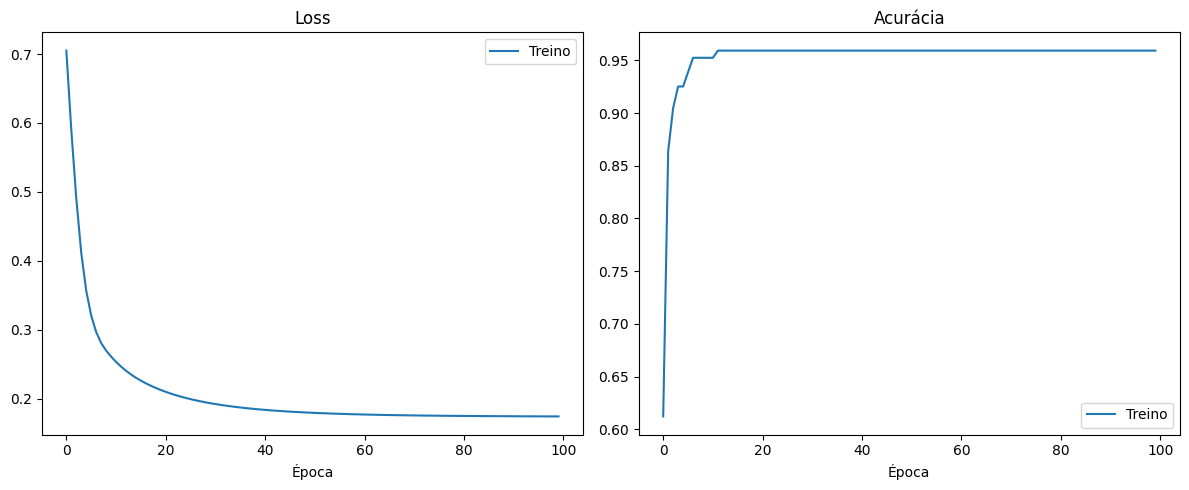

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 30° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,128,64,4],
                    activation='tanh',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.8082, Acc: 47.62%
Época 10/100 - Loss Treino: 0.5734, Acc: 47.62%
Época 20/100 - Loss Treino: 0.5104, Acc: 47.62%
Época 30/100 - Loss Treino: 0.4716, Acc: 47.62%
Época 40/100 - Loss Treino: 0.4406, Acc: 47.62%
Época 50/100 - Loss Treino: 0.4129, Acc: 47.62%
Época 60/100 - Loss Treino: 0.3871, Acc: 98.64%
Época 70/100 - Loss Treino: 0.3634, Acc: 98.64%
Época 80/100 - Loss Treino: 0.3417, Acc: 98.64%
Época 90/100 - Loss Treino: 0.3217, Acc: 98.64%
Época 100/100 - Loss Treino: 0.3032, Acc: 98.64%
Tempo total de treinamento: 0.72 segundos

Acurácia do Teste: 82.54%


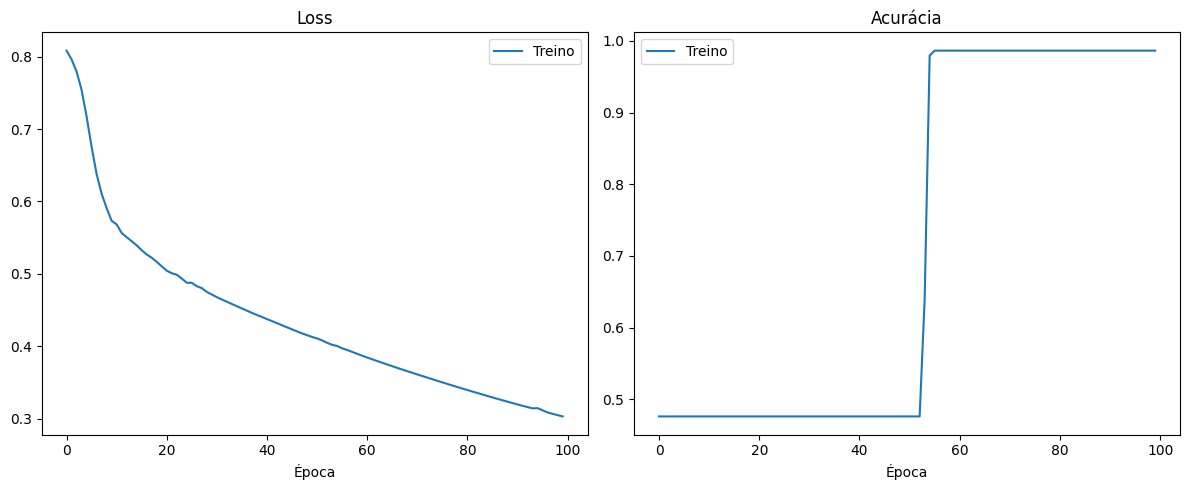

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 31° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu',)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7298, Acc: 51.02%
Época 10/100 - Loss Treino: 0.2395, Acc: 95.24%
Época 20/100 - Loss Treino: 0.1936, Acc: 95.92%
Época 30/100 - Loss Treino: 0.1804, Acc: 95.92%
Época 40/100 - Loss Treino: 0.1744, Acc: 95.92%
Época 50/100 - Loss Treino: 0.1714, Acc: 95.92%
Época 60/100 - Loss Treino: 0.1697, Acc: 95.92%
Época 70/100 - Loss Treino: 0.1688, Acc: 95.92%
Época 80/100 - Loss Treino: 0.1682, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1678, Acc: 95.92%
Época 100/100 - Loss Treino: 0.1676, Acc: 95.92%
Tempo total de treinamento: 0.72 segundos

Acurácia do Teste: 87.30%


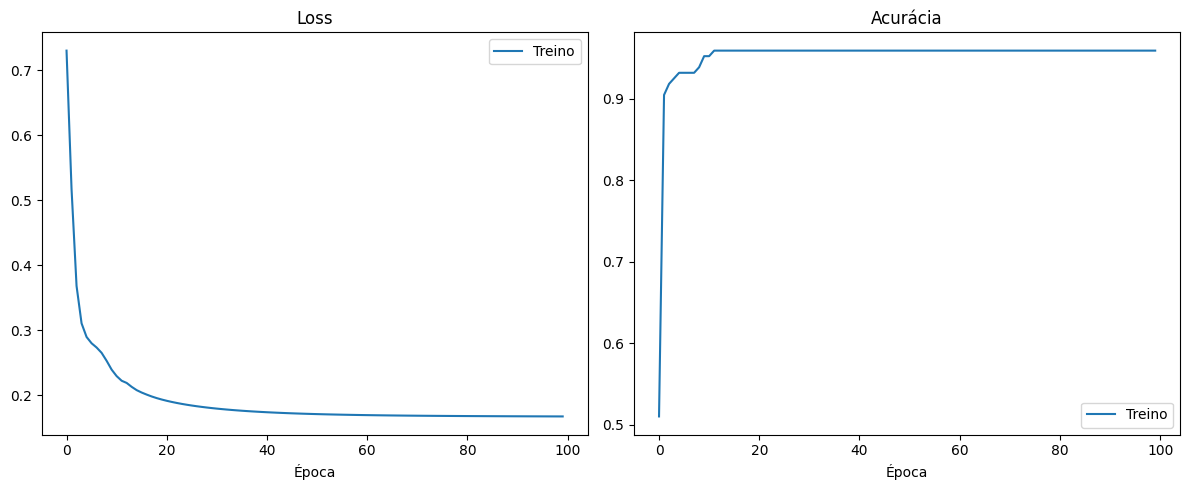

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 32° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh',)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.8301, Acc: 52.38%
Época 10/100 - Loss Treino: 0.3079, Acc: 90.48%
Época 20/100 - Loss Treino: 0.1280, Acc: 96.60%
Época 30/100 - Loss Treino: 0.0943, Acc: 96.60%
Época 40/100 - Loss Treino: 0.0760, Acc: 97.96%
Época 50/100 - Loss Treino: 0.0603, Acc: 97.28%
Época 60/100 - Loss Treino: 0.0359, Acc: 98.64%
Época 70/100 - Loss Treino: 0.0429, Acc: 97.96%
Época 80/100 - Loss Treino: 0.0443, Acc: 96.60%
Época 90/100 - Loss Treino: 0.0275, Acc: 97.96%
Época 100/100 - Loss Treino: 0.0196, Acc: 98.64%
Tempo total de treinamento: 0.89 segundos

Acurácia do Teste: 88.89%


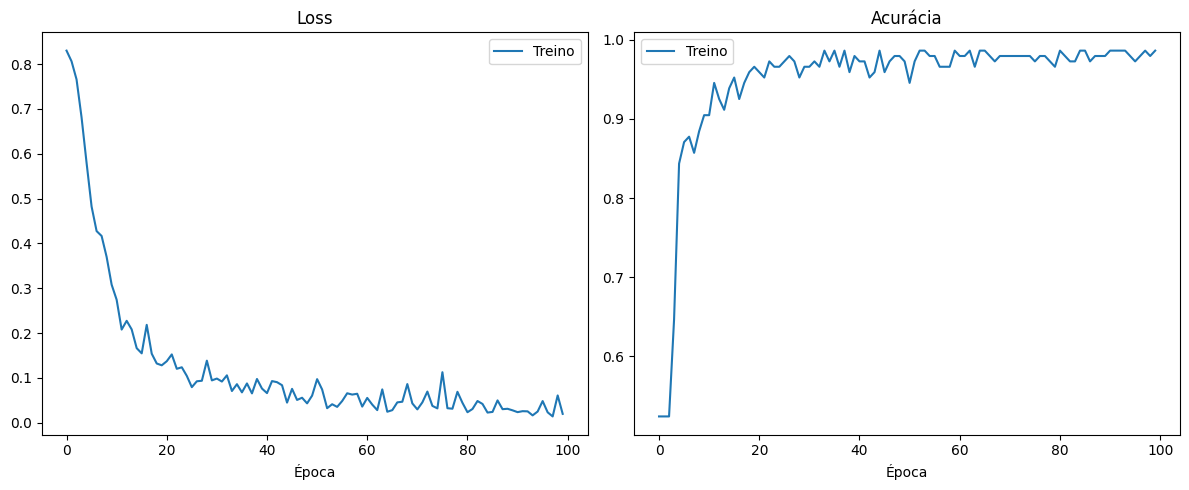

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 33° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.6856, Acc: 68.03%
Época 10/100 - Loss Treino: 0.3039, Acc: 91.84%
Época 20/100 - Loss Treino: 0.2338, Acc: 93.20%
Época 30/100 - Loss Treino: 0.2583, Acc: 93.20%
Época 40/100 - Loss Treino: 0.2183, Acc: 94.56%
Época 50/100 - Loss Treino: 0.1890, Acc: 95.24%
Época 60/100 - Loss Treino: 0.1885, Acc: 95.24%
Época 70/100 - Loss Treino: 0.1843, Acc: 95.92%
Época 80/100 - Loss Treino: 0.1973, Acc: 94.56%
Época 90/100 - Loss Treino: 0.1841, Acc: 95.92%
Época 100/100 - Loss Treino: 0.2045, Acc: 95.24%
Tempo total de treinamento: 0.93 segundos

Acurácia do Teste: 85.71%


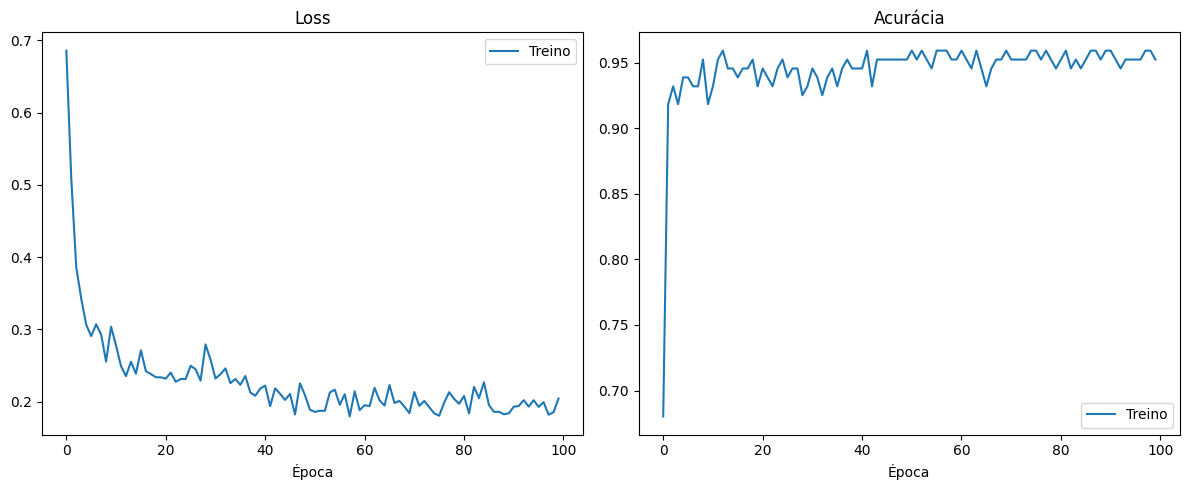

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 34° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.8134, Acc: 47.62%
Época 10/100 - Loss Treino: 0.2046, Acc: 95.24%
Época 20/100 - Loss Treino: 0.0630, Acc: 97.96%
Época 30/100 - Loss Treino: 0.0228, Acc: 99.32%
Época 40/100 - Loss Treino: 0.0071, Acc: 100.00%
Época 50/100 - Loss Treino: 0.0025, Acc: 100.00%
Época 60/100 - Loss Treino: 0.0020, Acc: 100.00%
Época 70/100 - Loss Treino: 0.0018, Acc: 100.00%
Época 80/100 - Loss Treino: 0.0016, Acc: 100.00%
Época 90/100 - Loss Treino: 0.0015, Acc: 100.00%
Época 100/100 - Loss Treino: 0.0014, Acc: 100.00%
Tempo total de treinamento: 0.76 segundos

Acurácia do Teste: 85.71%


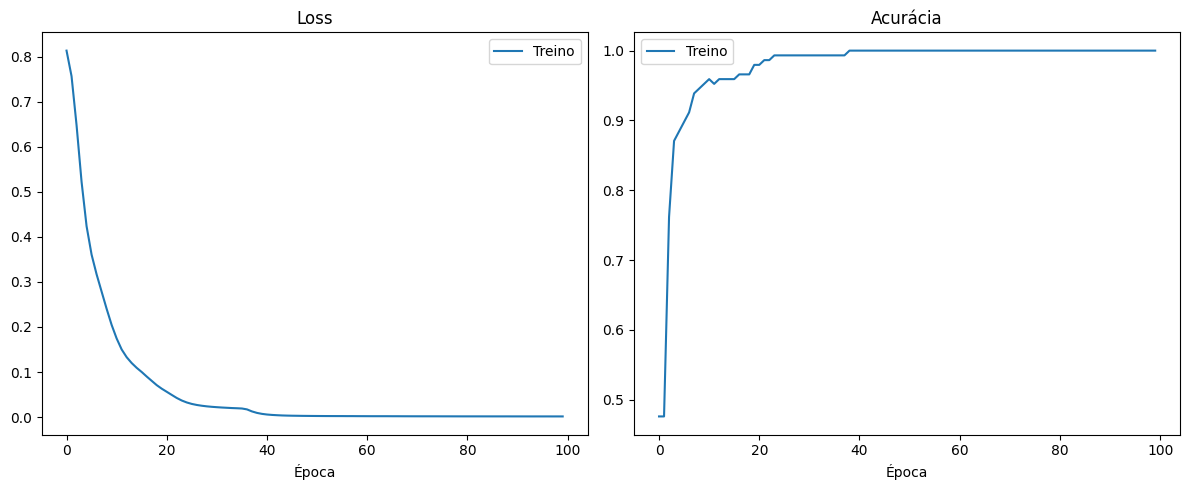

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 35° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='relu',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.6880, Acc: 65.31%
Época 10/100 - Loss Treino: 0.2501, Acc: 94.56%
Época 20/100 - Loss Treino: 0.2161, Acc: 95.24%
Época 30/100 - Loss Treino: 0.2054, Acc: 95.24%
Época 40/100 - Loss Treino: 0.2008, Acc: 95.24%
Época 50/100 - Loss Treino: 0.1987, Acc: 95.24%
Época 60/100 - Loss Treino: 0.1977, Acc: 95.24%
Época 70/100 - Loss Treino: 0.1774, Acc: 95.92%
Época 80/100 - Loss Treino: 0.1557, Acc: 96.60%
Época 90/100 - Loss Treino: 0.1543, Acc: 96.60%
Época 100/100 - Loss Treino: 0.1536, Acc: 96.60%
Tempo total de treinamento: 0.74 segundos

Acurácia do Teste: 80.95%


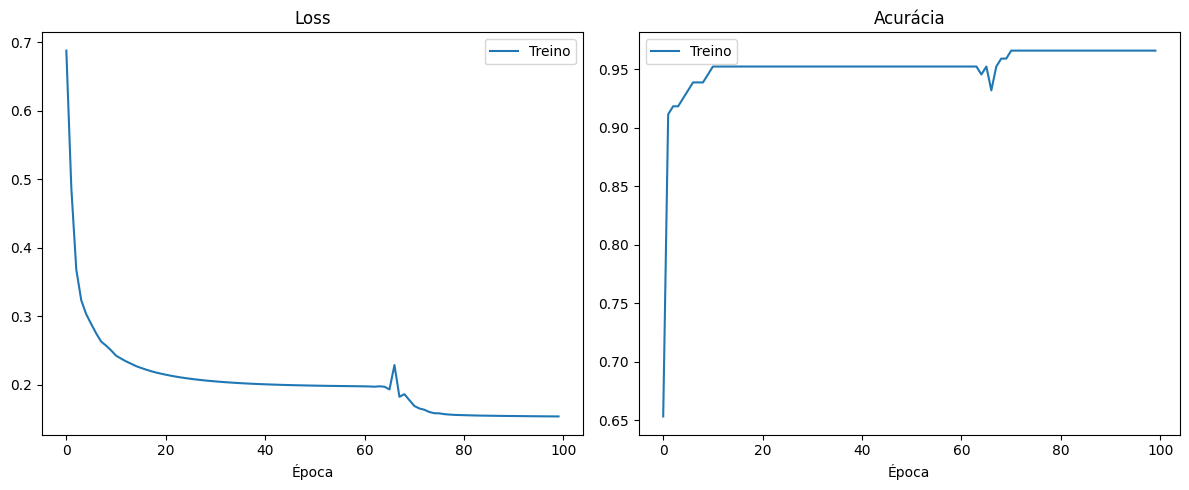

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [ ]:
# 36° Caso
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[50,256,128,64,4],
                    activation='tanh',
                    regularization='l2',
                    lambda_l2=0.001)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)